In [1]:
%run uvms_forward_dynamics.ipynb

jit after {'jit': True, 'jit_options': {'flags': '-Ofast'}, 'compiler': 'shell'}
number of joints = 4
floating_base found
floating_base found
floating_base found
floating_base found
floating_base found
floating_base found


In [2]:
controller = control(arm_ss.n_joints)
pid_control = controller.uvms_position_controller()

number of joints = 4


In [3]:
def control(x ,v,  buffer, xref, alpha, blue):
    uv_g = uv_gn_func(x[2], [x[3],x[4],x[5]], blue.W, blue.B, blue.rg, blue.rb)
    uv_J = J_uv_func([x[3],x[4],x[5]])
    Kp = cs.vertcat(blue.kp, alpha.Kp)
    Ki = cs.vertcat(blue.ki, alpha.Ki)
    Kd = cs.vertcat(blue.kd, alpha.Kd)
    umin = cs.vertcat(blue.u_min, alpha.u_min)
    umax = cs.vertcat(blue.u_max, alpha.u_max)
    fu = pid_control(x, v, xref, uv_g , uv_J, Kp, Ki, Kd,  buffer , alpha.delta_t, umin, umax)
    return fu[0].full().flatten() , fu[1].full().flatten()

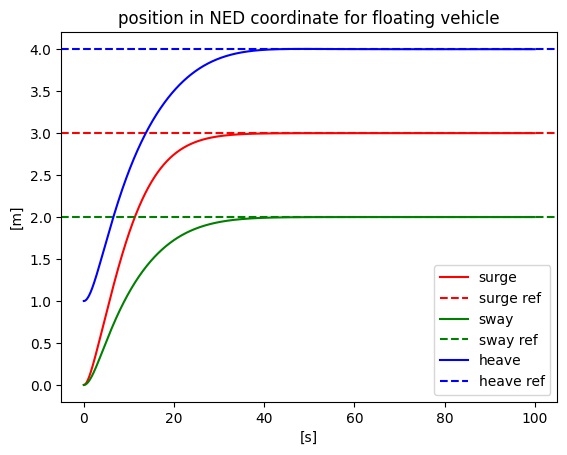

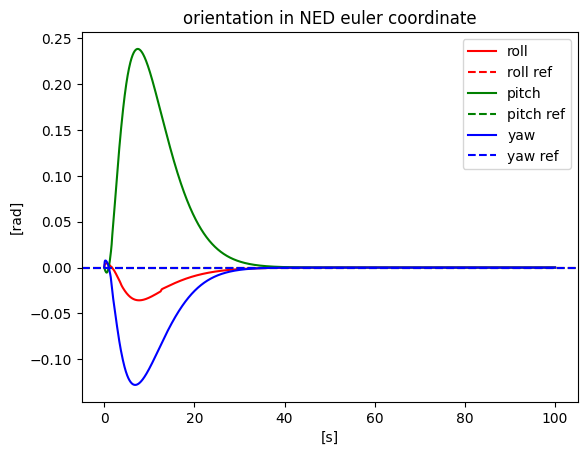

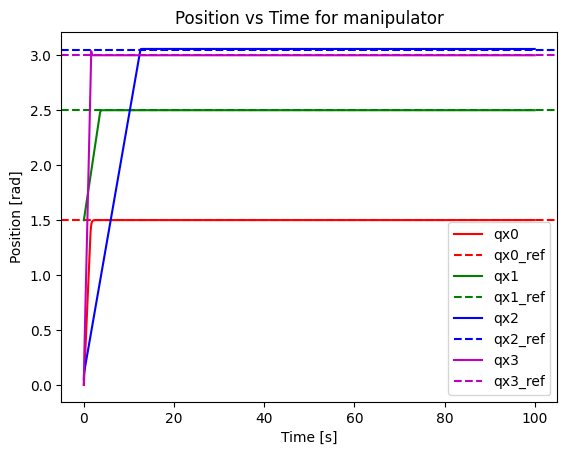

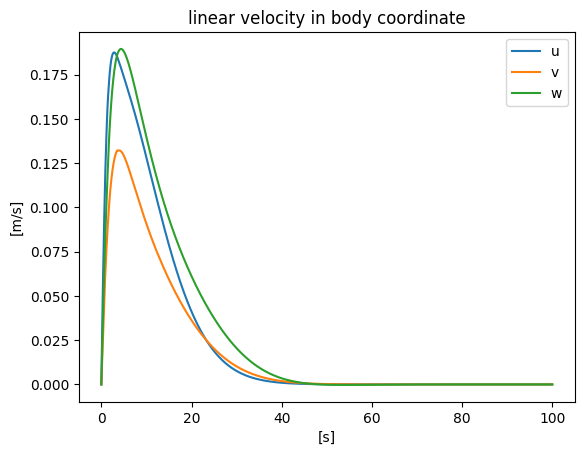

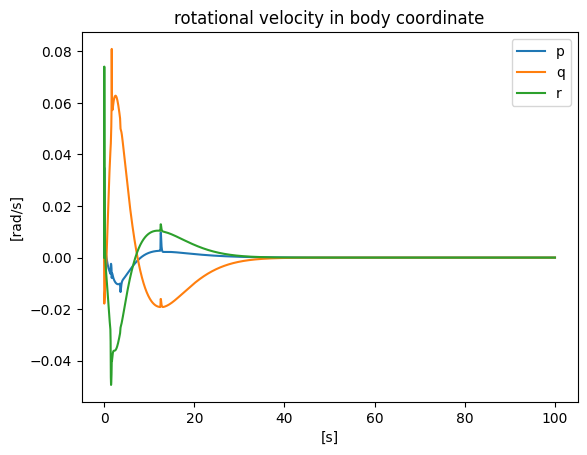

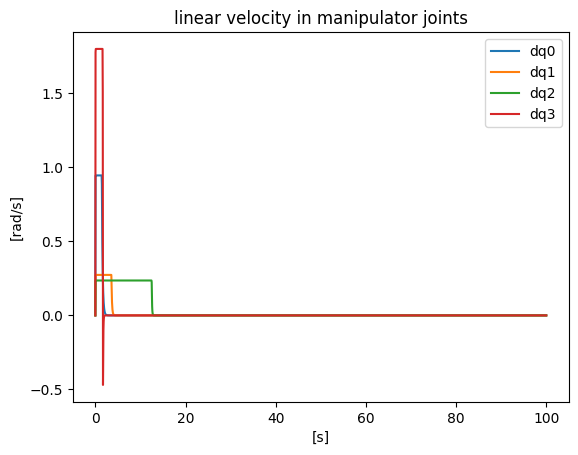

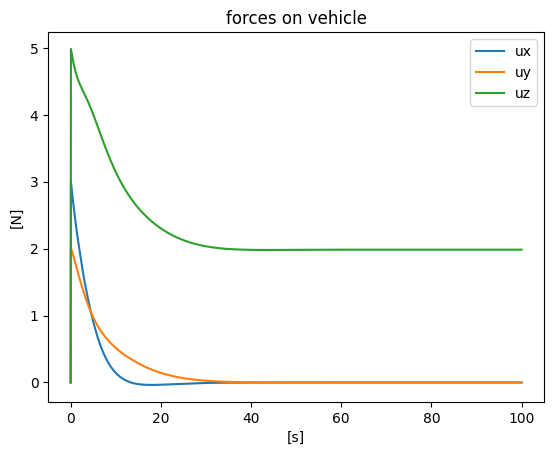

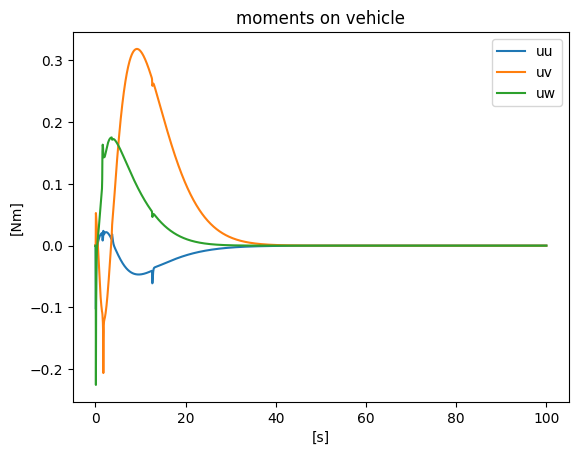

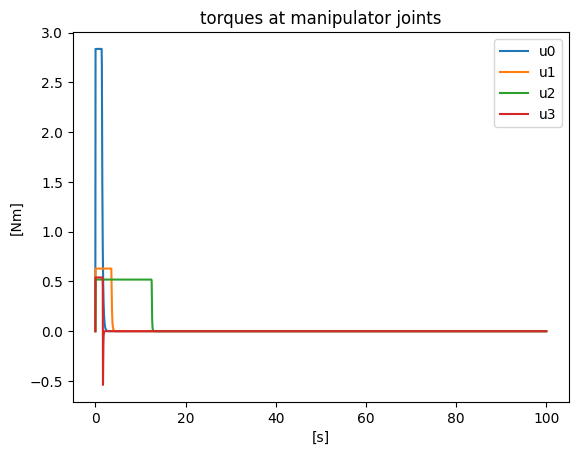

In [5]:
res = [np.zeros((20,alpha.N+1)), np.zeros((10,alpha.N+1))]
x0 = np.array([0, 0, 1, 0, 0, 0, 0.0, 1.5, 0.05, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #x y z r p y q0 q1 q2 q3 u v w p q r qd0 qd1 qd2 qd3 qd4

xref = np.array([3, 2, 4, 0, 0, 0,  1.5, 2.5, 3.05, 3.0]) #x y z r p y q0 q1 q2 q3
u =  np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0])
res[0][:,0] = x0
res[1][:,0] = u
t = np.linspace(0, alpha.sim_n, alpha.N+1)
sebuffer_ = np.array([0,0,0,0,0,0, 0,0,0,0])

for i in range(1, alpha.N+1):
  u , sebuffer_ = control(res[0][:10,i-1],res[0][10:,i-1], sebuffer_,xref, alpha, blue)

  fx = UVMSnext_use_coupled(use_coupled, res[0][:,i-1], u, alpha.delta_t, blue.sim_p, alpha.sim_p,  alpha.base_T0, alpha.joint_min, alpha.joint_max)
  res[0][:,i] = fx[0].full().flatten()
  res[1][:,i] = fx[1].full().flatten()

# Create a figure and plot the data
plt.figure()
plt.plot(t, res[0][0,:].T, color='r', label=f'x')
plt.axhline(y=xref[0], color='r', linestyle='--')

plt.plot(t, res[0][1,:].T, color='g', label=f'y')
plt.axhline(y=xref[1], color='g', linestyle='--')

plt.plot(t, res[0][2,:].T, color='b', label=f'z')
plt.axhline(y=xref[2], color='b', linestyle='--')

plt.legend(['surge', 'surge ref', 'sway','sway ref', 'heave', 'heave ref'])
plt.title("position in NED coordinate for floating vehicle")
plt.xlabel('[s]')
plt.ylabel('[m]')

plt.figure()
plt.plot(t, res[0][3,:].T, color='r', label=f'r')
plt.axhline(y=xref[3], color='r', linestyle='--')

plt.plot(t, res[0][4,:].T, color='g', label=f'p')
plt.axhline(y=xref[4], color='g', linestyle='--')

plt.plot(t, res[0][5,:].T, color='b', label=f'y')
plt.axhline(y=xref[5], color='b', linestyle='--')

plt.legend(['roll', 'roll ref', 'pitch', 'pitch ref', 'yaw', 'yaw ref'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('[s]')
plt.ylabel('[rad]')

plt.figure()
# Position plot
plt.plot(t, res[0][6,:].T, color='r', label=f'qx{1}')
plt.axhline(y=xref[6], color='r', linestyle='--')

plt.plot(t, res[0][7,:].T, color='g', label=f'qx{2}')
plt.axhline(y=xref[7], color='g', linestyle='--')

plt.plot(t, res[0][8,:].T, color='b', label=f'qx{3}')
plt.axhline(y=xref[8], color='b', linestyle='--')

plt.plot(t, res[0][9,:].T, color='m', label=f'qx{4}')
plt.axhline(y=xref[9], color='m', linestyle='--')
plt.title('Position vs Time for manipulator')
plt.xlabel('Time [s]')
plt.ylabel('Position [rad]')
plt.legend(['qx0', 'qx0_ref', 'qx1', 'qx1_ref', 'qx2', 'qx2_ref', 'qx3', 'qx3_ref'])


plt.figure()
plt.plot(t, res[0][10:13,:].T)
plt.legend(['u', 'v', 'w'])
plt.xlabel('[s]')
plt.ylabel('[m/s]')
plt.title("linear velocity in body coordinate")
plt.show()

plt.figure()
plt.plot(t, res[0][13:16,:].T)
plt.legend(['p', 'q', 'r'])
plt.xlabel('[s]')
plt.ylabel('[rad/s]')
plt.title("rotational velocity in body coordinate")
plt.show()

plt.figure()
plt.plot(t, res[0][16:20,:].T)
plt.legend(['dq0', 'dq1', 'dq2', 'dq3'])
plt.xlabel('[s]')
plt.ylabel('[rad/s]')
plt.title("linear velocity in manipulator joints")
plt.show()

plt.figure()
plt.plot(t, res[1][0:3,:].T)
plt.legend(['ux', 'uy', 'uz'])
plt.xlabel('[s]')
plt.ylabel('[N]')
plt.title("forces on vehicle")
plt.show()


plt.figure()
plt.plot(t, res[1][3:6,:].T)
plt.legend(['uu', 'uv', 'uw'])
plt.xlabel('[s]')
plt.ylabel('[Nm]')
plt.title("moments on vehicle")
plt.show()

plt.figure()
plt.plot(t, res[1][6:10,:].T)
plt.legend(['u0', 'u1', 'u2', 'u3'])
plt.xlabel('[s]')
plt.ylabel('[Nm]')
plt.title("torques at manipulator joints")
plt.show()